In [1]:
import cv2
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

from deepls.TSP2OptEnv import TSP2OptEnv

font = cv2.FONT_HERSHEY_COMPLEX_SMALL

In [2]:
from deepls.agent import GRCNRollingBaselineAgent
from torch import nn
import torch
from tqdm import tqdm

In [3]:
env = TSP2OptEnv(max_num_steps=20, num_nodes=20, data_f='../graph-convnet-tsp/data/tsp20_test_concorde.txt', shuffle_data=True)
env.reset()

In [9]:
agent_config = {
    'replay_buffer_size': 2,
    'minibatch_sz': 32,
    'model': {   
        "voc_edges_in": 3,
        "hidden_dim": 128,
        "num_layers": 15,
        "mlp_layers": 3,
        "aggregation": "mean",
        "node_dim": 2,
        'dont_optimize_policy_steps': 100,
    },
    'optim': {
        'step_size': 1e-7, 
        'step_size_critic': 0.005,
        'beta_m': 0.9, 
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'device': 'cuda'
}

In [10]:
agent = GRCNRollingBaselineAgent()
agent.agent_init(agent_config)

In [11]:
ckpt = torch.load('model-15-layer-RGCN-20-nodes-2022-06-11.ckpt', map_location=agent.device)

In [12]:
agent.net.load_state_dict(ckpt['net'])
agent.critic_baseline = 0.

In [29]:
best_opt_gaps = []
all_opt_gaps = []

In [30]:
for _ in range(10):
    
    # re-instantiate the agent
    agent = GRCNRollingBaselineAgent()
    agent.agent_init(agent_config)
    agent.net.load_state_dict(ckpt['net'])
    agent.critic_baseline = 0.
    
    rewards = []
    starts = []
    opts = []
    env.reset(fetch_next=True)
    rolling_baseline = env.state.tour_len
    rbs = []
    critic_baseline = []
    per_improve = []
    ve_error = []

    agent.set_train()
    for episode in tqdm(range(1000)):
        env.reset(fetch_next=False)
        state = env.get_state()
        action = agent.agent_start(state)
        starts.append(state[0].tour_len)
        best = float("inf")
        while True:
            # Take a random action
            state, reward, done = env.step(action)

            if done == True:
                agent.agent_end(reward)
                reward = state[1].tour_len
                rewards.append(reward)
                # best_baseline = max(best_baseline, reward)
                rolling_baseline = agent.critic_baseline
                # agent.rolling_baseline = rolling_baseline
                per_improve.append(-reward / starts[-1])
                rbs.append(rolling_baseline)
                ve_error.append(agent.critic_abs_err)
                opts.append(state[0].opt_tour_len)
                break
            else:
                action = agent.agent_step(reward, state)
    
    opt_gap = rewards / np.array(opts) - 1.
    best_opt_gaps.append(np.min(opt_gap))
    all_opt_gaps.append(opt_gap)

100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s]


In [18]:
np.mean(best_opt_gaps)

0.004298742840812575

0.01180414803937313

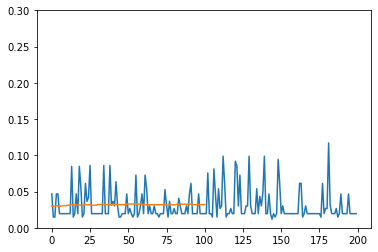

In [28]:
opt_gap = all_opt_gaps[0]
ma_opt_gap = np.convolve(np.array(opt_gap), np.ones(shape=(100,))/100., mode='valid')
plt.plot(opt_gap)
plt.plot(ma_opt_gap)
plt.ylim([0., 0.3])
np.min(opt_gap)